#Movie Reviews for Text and Sentiment Analysis

The data in this homework is 20k movie reviews which have been already labelled as positive or negative.   We will apply our text toolbox to see if we can fit an effective supervised model.

The Movie Review data can be [downloaded from this link](https://drive.google.com/uc?export=download&id=1UA9CyRd8y7Wi4RKruXfItXadT3hY92bE)

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
from sklearn.model_selection import train_test_split


In [13]:
# read in movie_reviews.csv
df = pd.read_csv('movie_reviews_20k.csv', engine='python')
df.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


The data is simply a full text review, and a rating of 0(bad) or 1(good), determined by a human labeller.


We need to remove HTML tags...you can run the following code to remove them.

In [14]:
# remove html tags
df['text'] = df['text'].apply(lambda x: re.sub('<[^<]+?>', '', x))

**1) Lets do all of the things we need to do to prepare text data.  Lemmatize, tokenize, removing stopwords and punctuation.  Feel free to grab the exact code from the `T9_SOTU` notebook (specifically the function `clean_text`) and run it.   Create a new field called "clean_review" and append it to your data frame, so that you retain the original text in one feature, and have the cleaned text in another feature. This will allow us to go back and look at the original text of the review when we are evaluating the model**

In [15]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk

# Download WordNet data for lemmatization
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Stopwords list
stop_words = set(stopwords.words('english'))

# Function to clean text (exactly your T9 version)
def clean_text(text):
    # Remove punctuation and lowercase the text
    text = re.sub(r'[^\w\s]', '', text.lower())

    # Remove numbers
    text = re.sub(r'[\d]', '', text)

    # Tokenize the text
    words = word_tokenize(text)

    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    # Join back into a single string
    return ' '.join(words)


df["clean_review"] = df["text"].apply(clean_text)
df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,label,clean_review
0,I grew up (b. 1965) watching and loving the Th...,0,grew b watching loving thunderbird mate school...
1,"When I put this movie in my DVD player, and sa...",0,put movie dvd player sat coke chip expectation...
2,Why do people who do not know what a particula...,0,people know particular time past like feel nee...
3,Even though I have great interest in Biblical ...,0,even though great interest biblical movie bore...
4,Im a die hard Dads Army fan and nothing will e...,1,im die hard dad army fan nothing ever change g...


**2) Split data into training and test.  Run a TFIDF Vectorizer on the cleaned reviews - you need to `fit` the Vectorizer to the training data, and then `transform` both the training and the test sets using the vectorizer.  Review our T9 notebooks for syntax.**

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Split the data
X = df['clean_review']
Y = df['label']

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# 2. Fit TF-IDF Vectorizer on training
tfidf_vectorizer = TfidfVectorizer(binary=True)
tfidf_vectorizer.fit(X_train)

# 3. Transform both training and test
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("Shapes:")
print("Train:", X_train_tfidf.shape)
print("Test: ", X_test_tfidf.shape)

Shapes:
Train: (15999, 97676)
Test:  (4000, 97676)


**3) Fit your favorite classification model to the training set - you can use Logistic Regression (but be sure to regularlize!), or something more complex like XGBoost or Random Forests, or any other classification model.  Apply your model to the test set and report the AUC.**

AUC = 0.9497


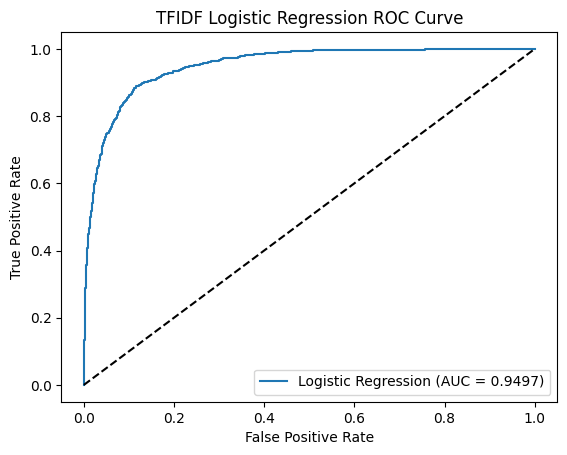

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt

# Fit model (regularized logistic regression)
LogReg_tfidf = LogisticRegression(solver='liblinear', C=1)
LogReg_tfidf.fit(X_train_tfidf, Y_train)

# Extract probabilities
probs = LogReg_tfidf.predict_proba(X_test_tfidf)[:, 1]
y_pred = LogReg_tfidf.predict(X_test_tfidf)

# Compute ROC + AUC
fpr, tpr, thresholds = metrics.roc_curve(Y_test, probs)
auc = metrics.roc_auc_score(Y_test, probs)

# Print AUC
print("AUC =", round(auc, 4))

# Plot ROC Curve
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.4f)' % auc)
plt.plot([0, 1], [0, 1], linestyle='dashed', color='black')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("TFIDF Logistic Regression ROC Curve")
plt.legend()
plt.show()

Multinomial Naive Bayes AUC = 0.9319


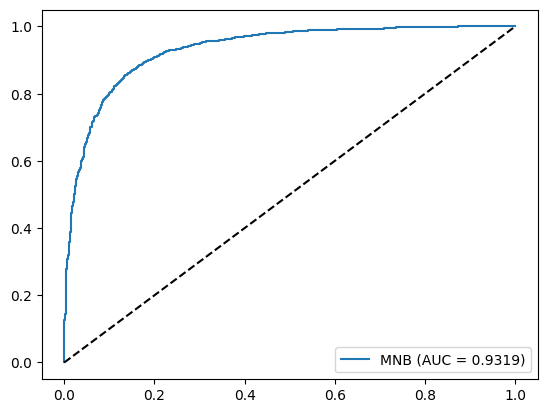

In [18]:
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt

mnb = MultinomialNB()
mnb.fit(X_train_tfidf, Y_train)

probs_mnb = mnb.predict_proba(X_test_tfidf)[:,1]
auc_mnb = roc_auc_score(Y_test, probs_mnb)

print("Multinomial Naive Bayes AUC =", round(auc_mnb, 4))

fpr, tpr, _ = roc_curve(Y_test, probs_mnb)
plt.plot(fpr, tpr, label=f"MNB (AUC = {auc_mnb:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()
plt.show()

Linear SVM (Calibrated) AUC = 0.9502


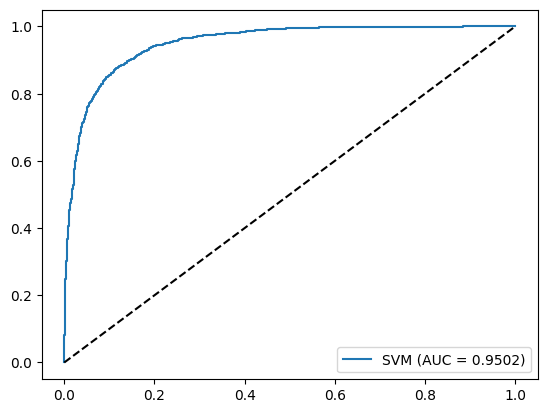

In [19]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# SVM doesn't output probabilities → wrap with calibration
svm = LinearSVC()
svm_calibrated = CalibratedClassifierCV(svm)
svm_calibrated.fit(X_train_tfidf, Y_train)

probs_svm = svm_calibrated.predict_proba(X_test_tfidf)[:,1]
auc_svm = roc_auc_score(Y_test, probs_svm)

print("Linear SVM (Calibrated) AUC =", round(auc_svm, 4))

fpr, tpr, _ = roc_curve(Y_test, probs_svm)
plt.plot(fpr, tpr, label=f"SVM (AUC = {auc_svm:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()
plt.show()

Random Forest AUC = 0.9282


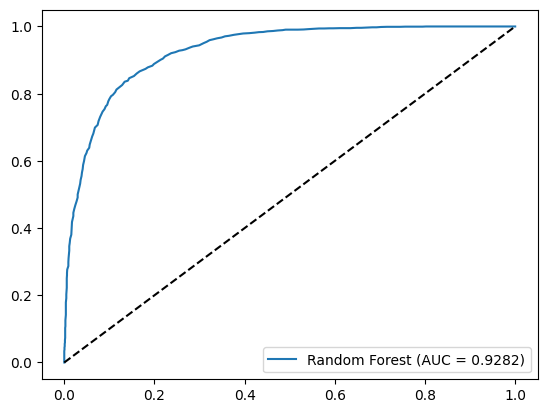

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train_tfidf, Y_train)

probs_rf = rf.predict_proba(X_test_tfidf)[:,1]
auc_rf = roc_auc_score(Y_test, probs_rf)

print("Random Forest AUC =", round(auc_rf, 4))

fpr, tpr, _ = roc_curve(Y_test, probs_rf)
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {auc_rf:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()
plt.show()

XGBoost AUC = 0.9223


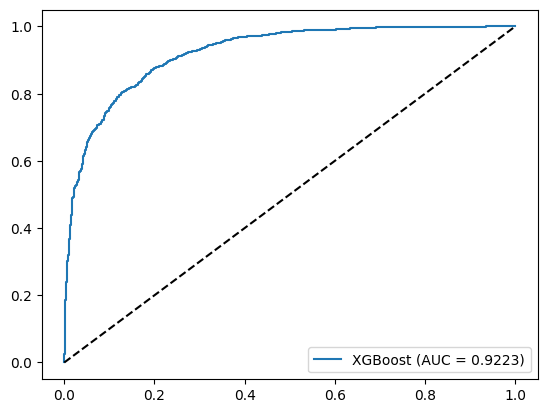

In [22]:
!pip install xgboost
from xgboost import XGBClassifier

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1
)

xgb.fit(X_train_tfidf, Y_train)

probs_xgb = xgb.predict_proba(X_test_tfidf)[:,1]
auc_xgb = roc_auc_score(Y_test, probs_xgb)

print("XGBoost AUC =", round(auc_xgb, 4))

fpr, tpr, _ = roc_curve(Y_test, probs_xgb)
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {auc_xgb:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()
plt.show()

In [40]:
auc_scores = {}
auc_scores["Logistic Regression"] = auc
auc_scores["Naive Bayes"] = auc_mnb
auc_scores["Linear SVM"] = auc_svm
auc_scores["Random Forest"] = auc_rf
auc_scores["XGBoost"] = auc_xgb

In [42]:
# Create AUC summary table
auc_table = pd.DataFrame({
    "Model": [
        "Logistic Regression",
        "Naive Bayes",
        "Linear SVM (Calibrated)",
        "Random Forest",
        "XGBoost"
    ],
    "AUC": [
        auc,
        auc_mnb,
        auc_svm,
        auc_rf,
        auc_xgb
    ]
})

# Sort by AUC descending
auc_table = auc_table.sort_values(by="AUC", ascending=False)

print("\n===== AUC SUMMARY TABLE =====")
print(auc_table.to_string(index=False))


===== AUC SUMMARY TABLE =====
                  Model      AUC
Linear SVM (Calibrated) 0.950151
    Logistic Regression 0.949669
            Naive Bayes 0.931947
          Random Forest 0.928194
                XGBoost 0.922272


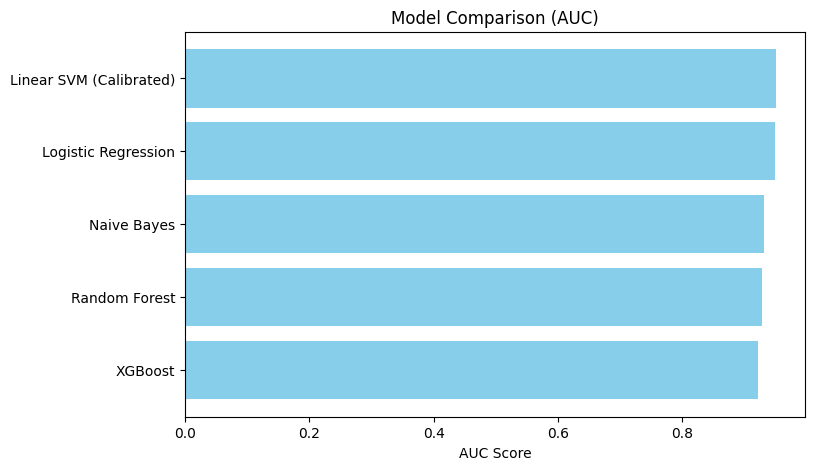

In [43]:
plt.figure(figsize=(8,5))
plt.barh(auc_table["Model"], auc_table["AUC"], color="skyblue")
plt.xlabel("AUC Score")
plt.title("Model Comparison (AUC)")
plt.gca().invert_yaxis()
plt.show()

**4) Find the P(label=1) for all cases in the test set.  Identify the review in the test set which has the _lowest_ probability of being a good review BUT has label=1 (good).  This might be a human labelling error!  Print the complete original review text for this error.  Do you think this is actually a good or bad review?  Do you think this error is due to an error in the human labelling (y_test) or is it a problem with the model?  Explain.**

In [25]:
# 1. Get probabilities
probs_test = LogReg_tfidf.predict_proba(X_test_tfidf)[:, 1]

# 2. Align Y_test and keep the ORIGINAL index
Y_test_series = Y_test.copy()

# 3. Find only the true positives
positive_indices = Y_test_series[Y_test_series == 1].index

positive_probs = probs_test[[X_test.index.get_loc(i) for i in positive_indices]]

# 4. Find index of lowest probability among true positives
min_prob_local_idx = np.argmin(positive_probs)
min_prob_true_index = positive_indices[min_prob_local_idx]

# 5. Extract exact values
lowest_prob = probs_test[X_test.index.get_loc(min_prob_true_index)]
true_label = Y_test_series.loc[min_prob_true_index]
original_review = df.loc[min_prob_true_index, "text"]
cleaned_review = df.loc[min_prob_true_index, "clean_review"]

print("Lowest P(label=1) among true positives:")
print("Probability:", lowest_prob)
print("True label:", true_label)

print("\nOriginal Review:")
print(original_review)

print("\nCleaned Review (optional):")
print(cleaned_review)

Lowest P(label=1) among true positives:
Probability: 0.041565672323246636
True label: 1

Original Review:
I have never seen such a movie before. I was on the edge of my seat and constantly laughing throughout the entire movie. I never thought such horrible acting existed it was all just too funny. The story behind the movie is decent but the movies scenes fail to portray them. I have never seen such a stupid movie in my life which is why it I think its worth watching. I give this movie 10 out of 10 for being the most pathetic movie ever created, this movie seems like it was solely created to become trash. I mean the scenes seem so fake and the actors act like "the camera is in front of them". You will get a kick just watching how lame this movie is, me and my friend could not stop making jokes during the movie, the darthvader guy who tries to get the girl got ran over not once but twice and the second time he got ran over it sounded like he said sh!# although he doesn't speak English l

I personally think this could be a human labeling error, the review uses scarcasm to put down the movie and the model honestly gave it a very low score, if there was a probablistic threshold on the classification this could have panned out to be correctly classified.

**5) To get an objective view of whether this review is _really_ positive or negative, we can use a pre-defined sentiment model built off of an existing lexicon.  One such model is called Vader.  [documentation here](https://medium.com/@rslavanyageetha/vader-a-comprehensive-guide-to-sentiment-analysis-in-python-c4f1868b0d2e).  Using your incorrectly labelled review from the last probem and the Vader code below, report what the negativity score is from Vader ('neg' in the output). Does this support your conclusion about the error above?**

In [26]:
nltk.download('vader_lexicon')

# Import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

text = original_review
scores = analyzer.polarity_scores(text)
print(scores)

{'neg': 0.123, 'neu': 0.694, 'pos': 0.183, 'compound': 0.9745}


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Vader gives a very positive compound score (0.9745) for a clearly negative review strongly supports the idea that:

1. This review is mislabeled due to a human labeling error, not a model error.

2. And Vader confirms that lexicon models cannot interpret sarcasm well.

Both the logistic regression model and Vader fail to interpret sarcasm correctly, but the logistic regression model at least gave a probability (0.04) that matched the true sentiment of the review. Vader falsely outputs a strongly positive score.


**6) `eli5` is a Python library that tries to "explain" machine learning models.  It works for simple models like logistic regression as well as more complicated, black box models like XGBoost and Random Forests.   Look up the documentation for `eli5` and use it to show the words contributing most to positive and negative scores in your model.**

In [29]:
!pip install eli5
import eli5
from eli5.sklearn import explain_weights

In [30]:
eli5.show_weights(
    LogReg_tfidf,
    feature_names=tfidf_vectorizer.get_feature_names_out(),
    top=20
)

In [35]:
# 3. Text version (if notebook does not render HTML)
weights_text = eli5.format_as_text(
    eli5.explain_weights(
        LogReg_tfidf,
        feature_names=tfidf_vectorizer.get_feature_names_out(),
        top=20
    )
)

print(weights_text)

Explained as: linear model

Features with largest coefficients.
Caveats:
1. Be careful with features which are not
   independent - weights don't show their importance.
2. If scale of input features is different then scale of coefficients
   will also be different, making direct comparison between coefficient values
   incorrect.
3. Depending on regularization, rare features sometimes may have high
   coefficients; this doesn't mean they contribute much to the
   classification result for most examples.

y=1 top features
Weight  Feature   
------  ----------
+6.789  great     
+5.568  excellent 
+4.867  best      
+4.387  wonderful 
+3.971  perfect   
+3.956  amazing   
+3.805  love      
+3.726  definitely
+3.673  loved     
… 50230 more positive …
… 47427 more negative …
-3.457  supposed  
-3.721  worse     
-4.014  horrible  
-4.140  poor      
-4.250  nothing   
-4.600  terrible  
-4.865  boring    
-5.751  awful     
-6.000  waste     
-7.861  bad       
-8.003  worst     



In [39]:
eli5.show_weights(
    svm_calibrated.calibrated_classifiers_[0].estimator,   # Access the *fitted* SVM estimator
    vec=tfidf_vectorizer,       # Pass the vectorizer explicitly
    feature_names=tfidf_vectorizer.get_feature_names_out(),
    top=20
)

In [38]:
# Text version (if notebook does not render HTML)
weights_svm_text = eli5.format_as_text(
    eli5.explain_weights(
        svm_calibrated.calibrated_classifiers_[0].estimator, # Access the *fitted* SVM estimator
        vec=tfidf_vectorizer,
        feature_names=tfidf_vectorizer.get_feature_names_out(),
        top=20
    )
)

print(weights_svm_text)

Explained as: linear model

Features with largest coefficients.
Caveats:
1. Be careful with features which are not
   independent - weights don't show their importance.
2. If scale of input features is different then scale of coefficients
   will also be different, making direct comparison between coefficient values
   incorrect.
3. Depending on regularization, rare features sometimes may have high
   coefficients; this doesn't mean they contribute much to the
   classification result for most examples.

y=1 top features
Weight  Feature       
------  --------------
+3.182  great         
+2.803  excellent     
+2.530  wonderful     
+2.472  best          
+2.304  amazing       
+2.281  perfect       
+2.273  definitely    
+2.232  favorite      
… 38924 more positive …
… 35391 more negative …
-2.086  worse         
-2.188  disappointment
-2.196  poor          
-2.224  poorly        
-2.458  fails         
-2.458  lame          
-2.557  terrible      
-2.777  boring        
-3.461  was